In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [5]:
import numpy as np
import pandas as pd

In [6]:
import math

In [7]:
import seaborn as sns
import random
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stt
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Alistirmayi kaggle'dan buldugum "Boston Housing Prices" adli data set ile yapacagim. Bu data set Boston mahallelerindeki median ev fiyatlarini iceriyor. Kuracagim random forest modeliyle her bir mahalle icin ev fiyatlarini tahmin etmeye calisacagim. Bunun icin data set'teki degiskenleri kullanacagim.

In [8]:
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

In [9]:
PATH = r"C:\Users\egeze\OneDrive\Masaüstü\Professional\Data_Science\DSPG\Homework/"

In [10]:
df = pd.read_csv(f'{PATH}housing.csv', header = None, delim_whitespace = True, names = names, low_memory = False)

In [11]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [12]:
df.columns = names

In [13]:
display_all(df.head())

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [14]:
shape(df)

(506, 14)

**Metrik Secimim:** Fiyat tahmini yapacagim icin "underestimation"i cezalandirmak istiyorum. Bundan oturu metrigimi RMSE degil RMSLE olarak sececegim. Ne olur ne olmaz diye projenin ilerisinde RMSE'ye de bakacagim. Ancak simdilik RMSLE ile devam ediyorum.

In [15]:
# Tahmin etmek istedigim degiskeni logaritmik tabana aliyorum:

df['MDV'] = np.log(df.MEDV)

In [16]:
# Kontrol ediyorum:

display_all(df.head())

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV       MDV  
0     15.3  396.90   4.98  24.0  3.178054  
1     17.8  396.90   9.14  21.6  3.072693  
2     17.8  392.83   4.03  34.7  3.546740  
3     18.7  394.63   2.94  33.4  3.508556  
4     18.7  396.90   5.33  36.2  3.589059

Modelimi kurmadan once yapmam gerekenler:

- Kategorik degiskenler varsa (zip code dahil), sayiya cevir.
- Data set'ini train, validation ve test setlerine ayir.
- Eksik degerleri yerine koy.

**1. Kategorik Degiskenleri Numerik Degiskenlere Cevir:**

In [17]:
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [18]:
df_compare = df.copy()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
 14  MDV      506 non-null    float64
dtypes: float64(13), int64(2)
memory usage: 59.4 KB


Butun degiskenlerimiz numerik. Ikinci asamaya gecebiliriz.

**2. Data Set'ini Ayir:**

`shape()` fonksiyonundan oturu data frame'imde 502 satir oldugunu biliyorum. Random forest'im icin data setimi 2:2:1 oraniyla bolmeye karar verdim.

In [20]:
def split_df(df, i, ii):
    return df[:i].copy(), df[i:ii].copy(), df[ii:].copy()

In [21]:
train_df, valid_df, test_df = split_df(df, 202, 404)

In [22]:
len(test_df)

102

In [23]:
test_df.tail()

CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
501  0.06263  0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273.0   
502  0.04527  0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273.0   
503  0.06076  0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273.0   
504  0.10959  0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273.0   
505  0.04741  0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273.0   

     PTRATIO       B  LSTAT  MEDV       MDV  
501     21.0  391.99   9.67  22.4  3.109061  
502     21.0  396.90   9.08  20.6  3.025291  
503     21.0  396.90   5.64  23.9  3.173878  
504     21.0  393.45   6.48  22.0  3.091042  
505     21.0  396.90   7.88  11.9  2.476538

In [24]:
len(train_df)

202

In [25]:
len(valid_df)

202

**3. Eksik Degerleri Tamamla:**

In [26]:
# Once degerlerin eksik olup olmadigini gosteren bir kolon olusturacagiz.

def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes + 1

In [27]:
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV       MDV  
0     15.3  396.90   4.98  24.0  3.178054  
1     17.8  396.90   9.14  21.6  3.072693  
2     17.8  392.83   4.03  34.7  3.546740  
3     18.7  394.63   2.94  33.4  3.508556  
4     18.7  396.90   5.33  36.2  3.589059

Gordugum kadariyla hicbir degerim eksik degil cunku yeni bir kolon olusturulmamis. Dogrudan modellemeye gecebilirim.

**4. Modelleme:**

In [28]:
# Hizli okuyabilmek icin:

import os

In [29]:
os.makedirs('tmp', exist_ok = True)
df.to_feather('tmp/housing')

In [30]:
def proc_df(df, y_fld, nan_dict = None, is_train = True):
        
    df = df.copy()
    
    y = df[y_fld].values
    
    df.drop(y_fld, axis = 1, inplace = True) # Bu satir tahmin etmek istedigim degerleri df'den ayiracak
    
    if nan_dict is None:
        nan_dict = {}
        
    return df, y, nan_dict

In [31]:
df = pd.read_feather(r"tmp/housing")

In [32]:
x, y, nas = proc_df(train_df, 'MEDV')

In [33]:
x_valid, y_valid, nas = proc_df(valid_df, 'MEDV', nan_dict = nas, is_train = False)

In [34]:
x_test, y_test, nas_test = proc_df(test_df, 'MEDV', nan_dict = nas, is_train = False)

In [35]:
m = RandomForestRegressor(n_estimators = 10, n_jobs = -1)
m.fit(x, y)
m.score(x, y)

0.9987776112931837

R-square cok yuksek cikti. Datasetimiz kucuk oldugu icin overfitting yapiyor olabilir. Validation ve test data frame'lerinde de denememiz lazim.

In [36]:
def rmsle(x, y):
    return math.sqrt(((x - y)**2).mean())

In [37]:
def print_score(m):
    print(f"RMSLE of train set {rmsle(m.predict(x), y)}")
    print(f"RMSLE of validation set {rmsle(m.predict(x_valid), y_valid)}")
    print(f"R^2 of train set {m.score(x, y)}")
    print(f"R^2 of validation set {m.score(x_valid, y_valid)}")

In [38]:
m = RandomForestRegressor(n_estimators = 10, n_jobs = -1)
%time m.fit(x, y)
print_score(m)

Wall time: 25.2 ms
RMSLE of train set 0.41418296048060105
RMSLE of validation set 1.4431147556656057
R^2 of train set 0.9972423099222134
R^2 of validation set 0.9806114275992803


**Datasetim kucuk oldugu icin OOB score metodunu kullanarak modelimi modifiye etmeye karar verdim:**

In [39]:
def print_score(m):
    print(f"RMSLE of train set {rmsle(m.predict(x), y)}")
    print(f"RMSLE of validation set {rmsle(m.predict(x_valid), y_valid)}")
    print(f"R^2 of train set {m.score(x, y)}")
    print(f"R^2 of validation set {m.score(x_valid, y_valid)}")
    if hasattr(m, "oob_score"):
        print(f"OOB score: {m.oob_score_}")

In [40]:
m = RandomForestRegressor(n_estimators = 30, n_jobs = -1, oob_score = True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.21181402578241187
RMSLE of validation set 1.4514578991494382
R^2 of train set 0.999278775569107
R^2 of validation set 0.9803865955258321
OOB score: 0.9956800565496154


In [41]:
# Bagging ve bootstrapping ile...
#... modelin datayi ezberlemesinin onune gecmeye calisalim.

def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return idxs, df.iloc[idxs].copy()

In [42]:
idxs, x = get_sample(x, 100)
y = y[idxs]

In [43]:
m = RandomForestRegressor(n_estimators = 30, n_jobs = -1, oob_score = True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.5165731098090345
RMSLE of validation set 1.982848860594372
R^2 of train set 0.9962492411761975
R^2 of validation set 0.9633964403310732
OOB score: 0.9771023716167697


Simdi bir de optimal tree sayisini bulmaya calisalim.

In [44]:
y_valid.shape

(202,)

In [46]:
preds = np.array([t.predict(x_valid) for t in m.estimators_])
preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

(array([50. , 50. , 50. , 43.8, 43.8, 43.8, 34.9, 37. , 36.2, 50. , 43.8,
        43.8, 50. , 50. , 36.4, 43.8, 50. , 50. , 43.8, 34.9, 43.8, 50. ,
        43.8, 43.8, 43.8, 50. , 50. , 34.6, 34.9, 34.9]),
 43.85333333333333,
 42.3)

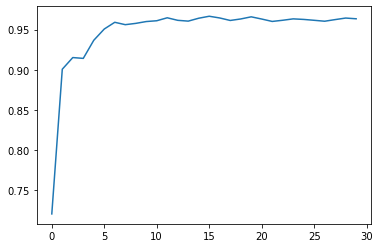

In [47]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i + 1], axis = 0)) for i in range(30)]);

In [48]:
# 7 agac optimal duruyor.
# Modelimi 30'dan 7 agac olacak sekilde degistiriyorum:

m = RandomForestRegressor(n_estimators = 7, n_jobs = -1, oob_score = True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.3031231985008533
RMSLE of validation set 1.8046607336864842
R^2 of train set 0.9987085015213591
R^2 of validation set 0.9696795783871762
OOB score: 0.1838360817114153


Ancak bu sefer de OOB score'um cok dustu. Agac sayisini yavasca arttirarak optimal olani bulmaya calisacagim.

In [49]:
m = RandomForestRegressor(n_estimators = 15, n_jobs = -1, oob_score = True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.6158037205329503
RMSLE of validation set 2.2186619720215632
R^2 of train set 0.9946698409784177
R^2 of validation set 0.9541724777111498
OOB score: 0.9698826802156043


In [50]:
# 21 iyi duruyor.
# 21'den sonra oob score dusmeye basliyor.

m = RandomForestRegressor(n_estimators = 21, n_jobs = -1, oob_score = True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.36224764458733255
RMSLE of validation set 1.6666180029266504
R^2 of train set 0.99815555083674
R^2 of validation set 0.9741407314894662
OOB score: 0.9849392264879155


**5. Tahminlere yakindan bakalim:**

In [53]:
# Ilk degerler icin modellerimin tahminleri:

preds[:, 0]

array([50. , 50. , 50. , 43.8, 43.8, 43.8, 34.9, 37. , 36.2, 50. , 43.8,
       43.8, 50. , 50. , 36.4, 43.8, 50. , 50. , 43.8, 34.9, 43.8, 50. ,
       43.8, 43.8, 43.8, 50. , 50. , 34.6, 34.9, 34.9])

In [54]:
# Tahminlerin ortalamasi:

np.mean(preds[:, 0])

# 43 bin dolar.

43.85333333333333

**6. Gorsellestirme:**

In [55]:
from sklearn import tree
import matplotlib.pyplot as plt

In [56]:
estimator = m.estimators_[0]

In [57]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 20), dpi = 1000)
tree.plot_tree(estimator, feature_names = df.columns, fontsize = 8, filled = True)

[Text(10659.099264705881, 14345.0, 'MEDV <= 3.351\nmse = 78.931\nsamples = 72\nvalue = 23.636'),
 Text(6684.375, 12835.0, 'MEDV <= 2.947\nmse = 16.245\nsamples = 58\nvalue = 19.723'),
 Text(3555.882352941176, 11325.0, 'MEDV <= 2.782\nmse = 3.842\nsamples = 25\nvalue = 15.523'),
 Text(2097.0588235294117, 9815.0, 'MEDV <= 2.653\nmse = 1.207\nsamples = 16\nvalue = 14.28'),
 Text(820.5882352941176, 8305.0, 'RM <= 5.237\nmse = 0.342\nsamples = 8\nvalue = 13.33'),
 Text(638.2352941176471, 6795.0, 'mse = 0.0\nsamples = 1\nvalue = 11.8'),
 Text(1002.9411764705882, 6795.0, 'MEDV <= 2.595\nmse = 0.091\nsamples = 7\nvalue = 13.5'),
 Text(364.70588235294116, 5285.0, 'DIS <= 2.728\nmse = 0.005\nsamples = 3\nvalue = 13.2'),
 Text(182.35294117647058, 3775.0, 'mse = 0.0\nsamples = 1\nvalue = 13.3'),
 Text(547.0588235294117, 3775.0, 'B <= 295.685\nmse = 0.002\nsamples = 2\nvalue = 13.167'),
 Text(364.70588235294116, 2265.0, 'mse = 0.0\nsamples = 1\nvalue = 13.2'),
 Text(729.4117647058823, 2265.0, 'mse 